In [23]:
# Import libraries and dependencies
import sys #Allows us to read files from other folders
#Allowing the jupyter notebook to read files from everyone's directory
sys.path.append('.\\Brian\\')
sys.path.append('.\\Francisco\\')
sys.path.append('.\\Soheil\\')
sys.path.append('.\\Mike\\')

from os import getenv
import os
import pandas as pd
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import numpy as np
from datetime import date, timedelta
from pathlib import Path

import os
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
#import talib
#from technical_analysis import indicators
#from technical import indicators


# Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

#neural network imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

%matplotlib inline


In [3]:
def get_bars_alpaca(start_date = pd.Timestamp("2016-01-01", tz="America/New_York").isoformat(),end_date = pd.Timestamp("2023-03-24", tz="America/New_York").isoformat() ,ticker='SOYB'):
    load_dotenv()
    alpaca_api_key=getenv('ALPACA_API_KEY')
    secret_key=getenv('ALPACA_SECRET_KEY')
    if type(alpaca_api_key) == 0:
        raise Exception("No ALPACA API KEY was loaded. Please save a .env file containing an ALPACA_API_KEY in the local directory.")
    if type(secret_key) == 0:
        raise Exception("No ALPACA SECRET KEY was loaded. Please save a .env file containing an ALPACA_SECRET_KEY in the local directory.")
    api=REST(key_id=alpaca_api_key,secret_key=secret_key)
    df=api.get_bars("SOYB", TimeFrame.Day, start_date, end_date, adjustment='raw').df
    return(df)

def make_features_targets(dataframe,close=True,volume=False,trade_count=False,vwap=True):
    if close == True:
        dataframe['previous_close']=dataframe['close'].shift(1)
    if volume == True:
        dataframe['previous_volume']=dataframe['volume'].shift(1)
    if trade_count == True:
        dataframe['previous_trade_count']=dataframe['trade_count'].shift(1)
    if vwap == True:
        dataframe['previous_vwap']=dataframe['vwap'].shift(1)
    dataframe.dropna(inplace=True)
    X=dataframe[dataframe.columns[dataframe.columns.str.contains('previous')]]
    y=dataframe[['close']]
    return(X,y)

def cl_make_features_targets(dataframe,close=True,SMA50=True,SMA200=True):
    
    
    if close == True:
        dataframe['previous_close']=dataframe['close'].shift(1)
    if SMA50 == True:
        dataframe['previous_SMA50']=dataframe['SMA50'].shift(1)
    if SMA200 == True:
        dataframe['previous_SMA200']=dataframe['SMA200'].shift(1)

    dataframe.dropna(inplace=True)
    X=dataframe[dataframe.columns[dataframe.columns.str.contains('previous')]]
    y=dataframe[['Signal']]
    return(X,y)

In [4]:
df_portfolio = get_bars_alpaca()

In [5]:



signals_df = df_portfolio.loc[:,["close"]]

short_window = 50
long_window = 200

# Create moving averages --> In this case we will use 50 and 200 days respectively
signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA200'] = signals_df['close'].rolling(window=long_window).mean()
signals_df['Signal'] = 0.0

# Create trading signal 0 / 1,
# where 1 is the short-window (SMA50) greater than the long-window (SMA200)
# and 0 is when the condition is not met
signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA50'][short_window:] > signals_df['SMA200'][short_window:], 1.0, 0.0
)

# Identify when does the signal value change in time
# Define both trade entry (1) and trade exit (-1)
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
initial_capital = float(200000)

# Share size
share_size = 100

signals_df['Position'] = share_size * signals_df['Signal']

signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']

signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum()

signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

signals_df

,close,SMA50,SMA200,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,
2016-01-04 05:00:00+00:00,17.2290,NaN,NaN,0.0,NaN,0.0,NaN,0.00,NaN,NaN,NaN,NaN
2016-01-05 05:00:00+00:00,17.1934,NaN,NaN,0.0,0.0,0.0,0.0,0.00,200000.00,200000.00,NaN,NaN
2016-01-06 05:00:00+00:00,17.2645,NaN,NaN,0.0,0.0,0.0,0.0,0.00,200000.00,200000.00,0.000000,0.000000
2016-01-07 05:00:00+00:00,17.3195,NaN,NaN,0.0,0.0,0.0,0.0,0.00,200000.00,200000.00,0.000000,0.000000
2016-01-08 05:00:00+00:00,17.3300,NaN,NaN,0.0,0.0,0.0,0.0,0.00,200000.00,200000.00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20 04:00:00+00:00,27.0900,27.98081,27.219639,1.0,0.0,100.0,0.0,2709.00,197369.78,200078.78,0.000009,0.000394
2023-03-21 04:00:00+00:00,26.8100,27.95781,27.211040,1.0,0.0,100.0,0.0,2681.00,197369.78,200050.78,-0.000140,0.000254
2023-03-22 04:00:00+00:00,26.3300,27.92521,27.200789,1.0,0.0,100.0,0.0,2633.00,197369.78,200002.78,-0.000240,0.000014


In [6]:
X, y = cl_make_features_targets(signals_df)
y

,Signal
timestamp,
2016-10-18 04:00:00+00:00,0.0
2016-10-19 04:00:00+00:00,0.0
2016-10-20 04:00:00+00:00,0.0
2016-10-21 04:00:00+00:00,0.0
2016-10-24 04:00:00+00:00,0.0
...,...
2023-03-20 04:00:00+00:00,1.0
2023-03-21 04:00:00+00:00,1.0
2023-03-22 04:00:00+00:00,1.0


In [7]:
training_start_date = '2017-01-01'    #'2021-03-01'
training_end_date = '2017-12-31' #'2022-02-28'
testing_start_date = '2018-01-01' #'2022-03-01'
testing_end_date = '2018-12-31' #'2023-02-28'
X_train=X.loc[training_start_date:training_end_date,:]
y_train=y.loc[training_start_date:training_end_date,:]
X_test=X.loc[testing_start_date:testing_end_date,:]
y_test=y.loc[testing_start_date:testing_end_date,:]
  
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_scaler = StandardScaler()
    
# Fit the scaler
X_scaler.fit(X_train)
    
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [8]:
nn_model = Sequential()
number_inputs = 2
hidden_nodes_layer1 = 6
hidden_nodes_layer2 = 3
number_classes = 1

#add layers
nn_model.add(Dense(units=hidden_nodes_layer1, input_shape=(X_train.shape[1],), activation="relu", input_dim=number_inputs))
nn_model.add(Dense(units=hidden_nodes_layer2, input_shape=(X_train.shape[1],), activation="relu"))

#add output layer
nn_model.add(Dense(units=number_classes, activation="sigmoid"))
nn_model.summary()

nn_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
nn_model_fit = nn_model.fit(X_train_scaled, y_train, epochs=400)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
8/8 [==============================] - 1s 2ms/step - loss: 0.3522 - accuracy: 0.6375
Epoch 2/400
8/8 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.6375
Epoch 3/400
8/8 [==============================] - 0s 3ms/step - loss: 0.3382 - accuracy: 0.6375
Epoch 4/400
8/8 [================

<AxesSubplot:>

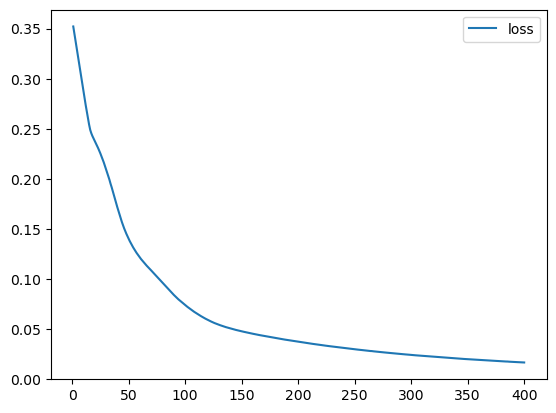

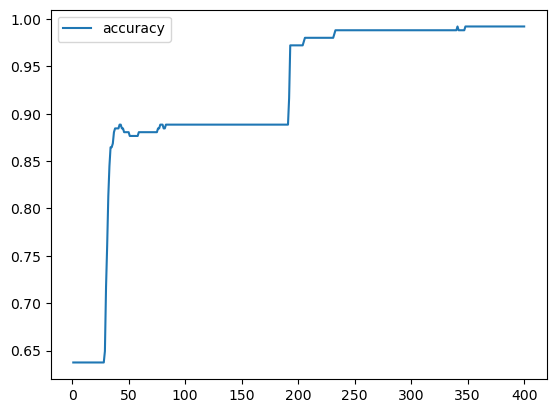

In [9]:
model_plot = pd.DataFrame(nn_model_fit.history, index=range(1, len(nn_model_fit.history["loss"]) + 1))
model_plot.plot(y="loss")
model_plot.plot(y="accuracy")

In [10]:
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)

# Display the evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.0785 - accuracy: 0.8924 - 134ms/epoch - 17ms/step
Loss: 0.07846403121948242, Accuracy: 0.892430305480957


In [11]:
file_path = Path("model.h5")

nn_model.save(file_path)

In [13]:
target_predicition = (nn_model.predict(X_test_scaled) > .5).astype("int32")


8/8 [==============================] - 0s 1ms/step


In [14]:
import tensorflow as tf
nn_model_imported = tf.keras.models.load_model(file_path)

model_loss, model_accuracy = nn_model_imported.evaluate(X_test_scaled, y_test, verbose=2)

8/8 - 0s - loss: 0.0785 - accuracy: 0.8924 - 109ms/epoch - 14ms/step


In [15]:
comparedf = pd.DataFrame(index = X_test.index)
comparedf['target'] = target_predicition
comparedf['actual signal'] = y_test
comparedf

,target,actual signal
timestamp,,
2018-01-02 05:00:00+00:00,1,1.0
2018-01-03 05:00:00+00:00,1,1.0
2018-01-04 05:00:00+00:00,1,1.0
2018-01-05 05:00:00+00:00,1,1.0
2018-01-08 05:00:00+00:00,1,1.0
...,...,...
2018-12-24 05:00:00+00:00,0,0.0
2018-12-26 05:00:00+00:00,0,0.0
2018-12-27 05:00:00+00:00,0,0.0


In [16]:
print(classification_report(y_true=comparedf['actual signal'],y_pred=comparedf['target']))

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.91       163
         1.0       0.79      0.94      0.86        88

    accuracy                           0.89       251
   macro avg       0.88      0.90      0.89       251
weighted avg       0.90      0.89      0.89       251

